---
title: EDA of Head Coaches dataset 
description: Exploratory data analysis of the head coaches dataset
---

### Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import pearsonr, pointbiserialr
from IPython.display import display, Markdown, HTML
from datetime import datetime

sns.set_style()
sns.set_theme(style = 'ticks', palette = 'pastel')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.bbox'] = 'tight'
sns.set_context("paper")

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.directory'] = 'figures'


### Loading data

In [2]:
head_coach = pd.read_csv('data/head_coach.csv', parse_dates=['appointed', 'end_date'])

### General information about data

Les données sur les coachs contiennent {eval}`head_coaches.shape[0]` enregistrement de coachs. 
À continuer...

In [3]:
long_tenure = head_coach[head_coach['days_in_post'] > 3000].shape[0]
head_coach = head_coach[head_coach['days_in_post'] <= 3000]

We will exclude head coaches with more than 3000 days in post. There are {eval}`long_tenure` head coaches with more than 3000 days in post.

To-Do : Explain that those are outliers

### Basic plots

In [4]:
# Useful to add xtick months to dayofyear plot
months = pd.date_range('2022-01-01', '2022-12-31', freq='ME').strftime('%b').tolist()

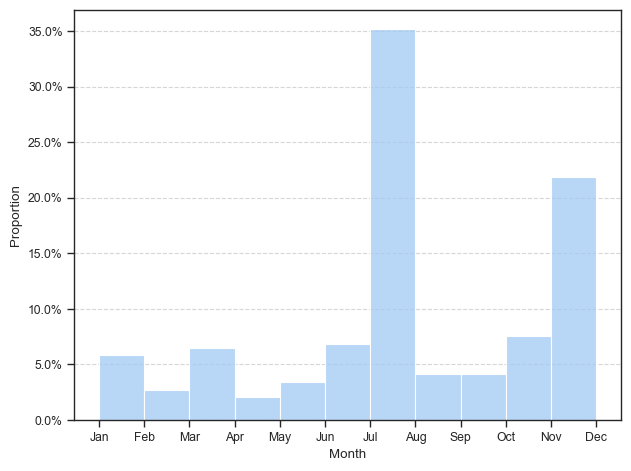

In [5]:
#| label: hc_appointment
plt.figure()
sns.histplot(head_coach['appointed'].dt.month, bins=11, color = 'b', kde=False, stat='density')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.xticks(range(1, 13), months)
# plt.title('Monthly Distribution of Head Coach Appointments')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.8)
# plt.savefig('figures/hc_appointment.png')

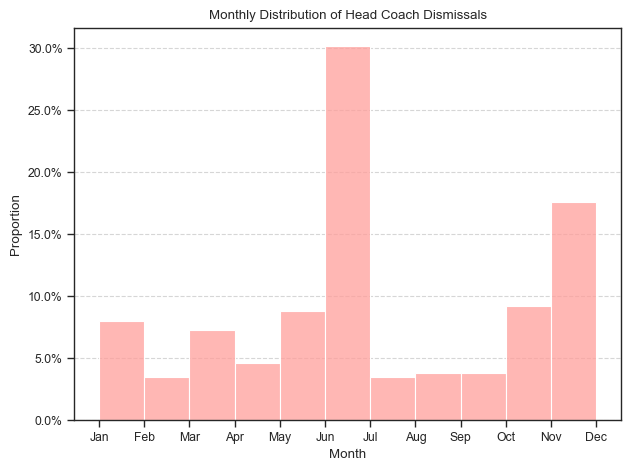

In [6]:
#| label: hc_dismissal
# Plot for Head Coach dismissal distribution
plt.figure()
sns.histplot(head_coach['end_date'].dt.month, bins=11, color = 'r', kde=False, stat='density')
plt.xticks(range(1, 13), months)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.title('Monthly Distribution of Head Coach Dismissals')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.8)
# plt.savefig('figures/hc_dismissal.png')

In [7]:
head_coach_dismissed = head_coach[head_coach['end_date'].notnull()]

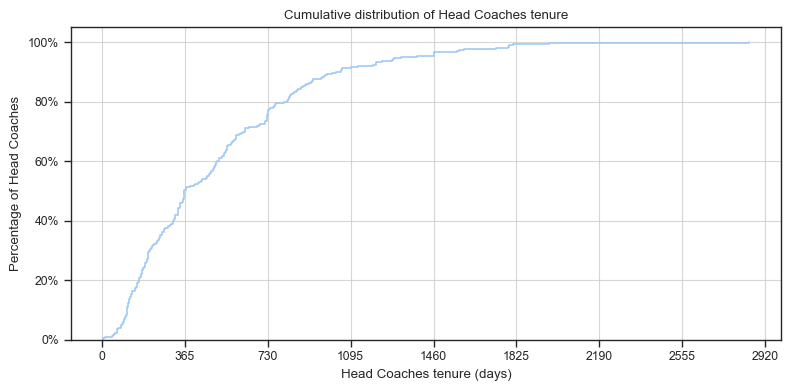

In [8]:
#| label: hc_tenure
# Plot ECDF of head_coach tenure 
plt.figure(figsize=(8, 4))

sns.ecdfplot(data=head_coach_dismissed, x='days_in_post', stat = 'percent')
plt.ylabel('Percentage of Head Coaches')
# Format percentage
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
# Grid
plt.grid(axis='y', linestyle='-', alpha=0.8)
plt.grid(axis='x', linestyle='-', alpha=0.8)
plt.xticks(range(0, max(head_coach_dismissed['days_in_post']) + 365, 365))
# plt.xlim(0, head_coach_dismissed['days_in_post'].quantile(0.97))
plt.title('Cumulative distribution of Head Coaches tenure')
plt.xlabel('Head Coaches tenure (days)');
# plt.savefig('figures/hc_tenure.png')

En moyenne, les coachs sont restés en poste {eval}`round(head_coach_dismissed['days_in_post'].mean())` jours.

Text(0, 0.5, '')

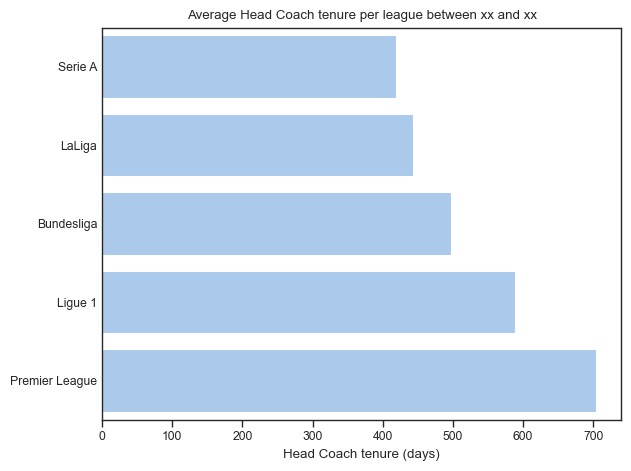

In [9]:
#| label: hc_tenure_per_league
# Average days in post per league 

# Calculate average days in post per league
avg_days_in_post = head_coach_dismissed.groupby('league')['days_in_post'].mean()
avg_days_in_post = avg_days_in_post.sort_values()

# Plot average days in post per league
plt.figure()
sns.barplot(y=avg_days_in_post.index, x=avg_days_in_post.values, orient='h')
plt.title('Average Head Coach tenure per league between xx and xx')
plt.xlabel('Head Coach tenure (days)')
plt.tick_params(axis='y', which='both', length=0)
# Disable ylabel
plt.ylabel('')

# plt.savefig('figures/hc_tenure_per_league.png')

In [31]:
head_coach_dismissed['league'] = head_coach_dismissed['league'].astype(str)

/var/folders/7l/wwrkhf0515x8dl_scksshbc00000gn/T/ipykernel_48539/1961330456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_coach_dismissed['league'] = head_coach_dismissed['league'].astype(str)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


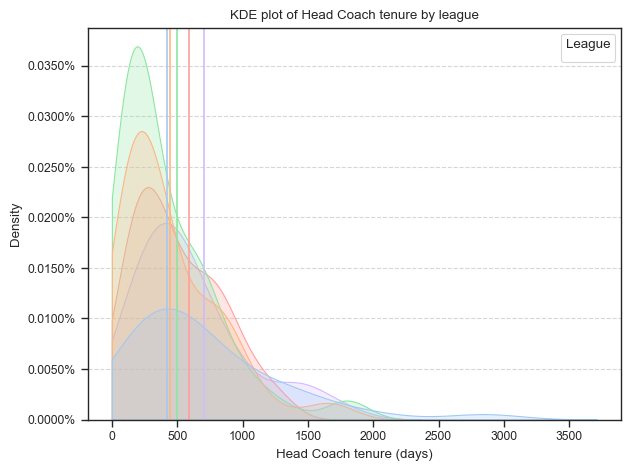

In [39]:
#| label: hc_tenure_per_league_kde
# KDE plot of headcoach tenure by league
plt.figure()

sns.kdeplot(data=head_coach_dismissed, x='days_in_post', hue='league', fill=True, common_norm=True, legend=True, palette='pastel', clip = (0, None))
plt.xlabel('Head Coach tenure (days)')
plt.ylabel('Density')
plt.title('KDE plot of Head Coach tenure by league')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.legend(title='League')
# Format percentage
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
# Add vertical line of same color as the league to represent the average tenure of the league
for i, league in enumerate(avg_days_in_post.index):
    plt.axvline(x=avg_days_in_post[league], color=sns.color_palette('pastel')[i], linestyle='-', alpha=1)
# plt.savefig('figures/hc_tenure_per_league_kde.png')

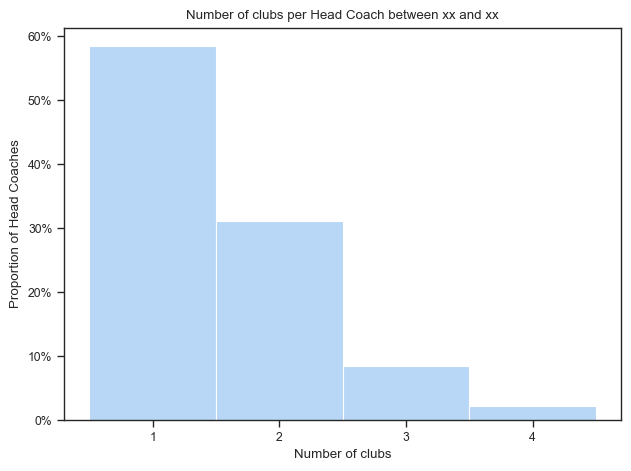

In [11]:
#| label: club_per_hc
# Number of clubs per Head Coach

# Group by coach_name and count the number of clubs
club_per_coach = head_coach.groupby('coach_name').size().reset_index(name='count')

plt.figure()
sns.histplot(x='count', data = club_per_coach, discrete = True, stat="probability")
plt.xticks(range(1, club_per_coach['count'].max() + 1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.title('Number of clubs per Head Coach between xx and xx')
plt.xlabel('Number of clubs')
plt.ylabel('Proportion of Head Coaches');
# plt.savefig('figures/number_of_club_per_coach.png')

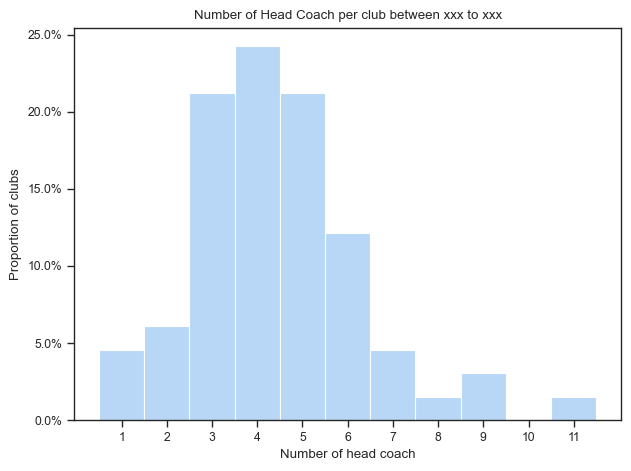

In [12]:
#| label: hc_per_club
# Number of Head Coachs per club

# Group by team and count the number of head coach
coach_per_club = head_coach.groupby('team').size().reset_index(name='count')

plt.figure()
sns.histplot(x='count', data = coach_per_club, discrete=True, stat="probability")
plt.xticks(range(1, coach_per_club['count'].max() + 1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.title(f'Number of Head Coach per club between xxx to xxx')
plt.xlabel('Number of head coach')
plt.ylabel('Proportion of clubs');
# plt.savefig('figures/number_of_coach_per_club.png')

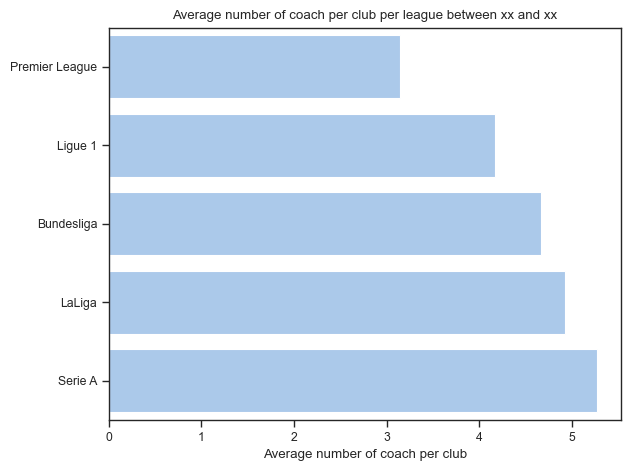

In [13]:
#| label: hc_per_club_per_league
# Average number of coach per club per league 

# Calculate average number of coach per club per league
coach_per_team = head_coach.groupby(['league', 'team']).size()
avg_number_of_coach_per_club_per_league = coach_per_team.groupby('league').mean().sort_values()

# Plot average number of coach per club per league
plt.figure()
sns.barplot(x=avg_number_of_coach_per_club_per_league.values, y=avg_number_of_coach_per_club_per_league.index, orient='h')
plt.title('Average number of coach per club per league between xx and xx')
plt.ylabel('')
plt.xlabel('Average number of coach per club');
# plt.savefig('figures/hc_per_club_per_league.png')

In [14]:
# Plot of wins, draw and losses percentage over days in post
head_coach['win_percentage'] = head_coach['wins'] / head_coach['matches'] * 100
head_coach['draw_percentage'] = head_coach['draws'] / head_coach['matches'] * 100
head_coach['loss_percentage'] = head_coach['losses'] / head_coach['matches'] * 100

def plot_percentage_over_days(data, y_value, y_leg, color):
    plt.figure()
    sns.regplot(x='days_in_post', y=y_value, data=data, color=sns.light_palette(color, as_cmap=True)(0.4), scatter_kws={'alpha':0.5}, label = y_leg + ' ratio')
    
    plt.title(f'{y_leg} ratio of Head Coaches appointments over Head Coaches tenure in club')
    ## x = head coach tenure in a club
    ## y = win/draw/loss ratio under the appointment of the head coach
    plt.xlabel('Head Coach tenure (days)')
    plt.ylabel(f'{y_leg.capitalize()} percentage')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    # Calculate Pearson correlation coefficient
    r, p = pearsonr(data['days_in_post'], data[y_value])
    plt.legend([f'Pearson correlation : r = {r:.2f}, p = {p:.2f}'], loc='upper right')
    
    # plt.savefig(f'figures/{y_value}_over_hc_tenure.png')

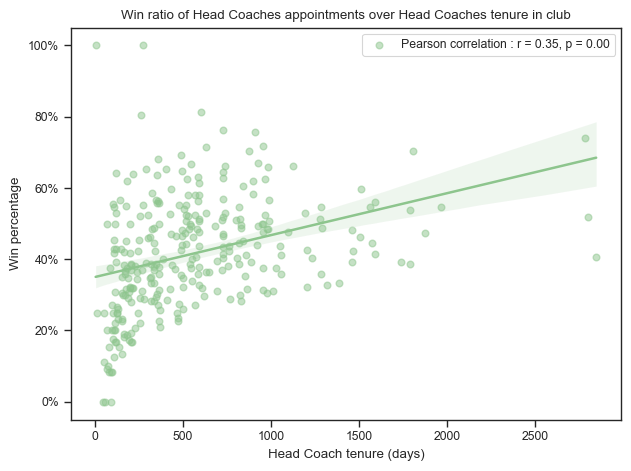

In [15]:
#| label: hc_win_ratio_over_days
plot_percentage_over_days(head_coach, 'win_percentage', 'Win', 'green')

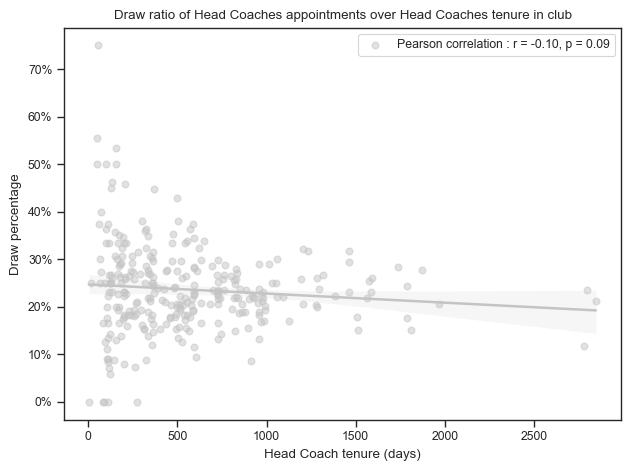

In [16]:
#| label: hc_draw_ratio_over_days
plot_percentage_over_days(head_coach, 'draw_percentage', 'Draw', 'gray')

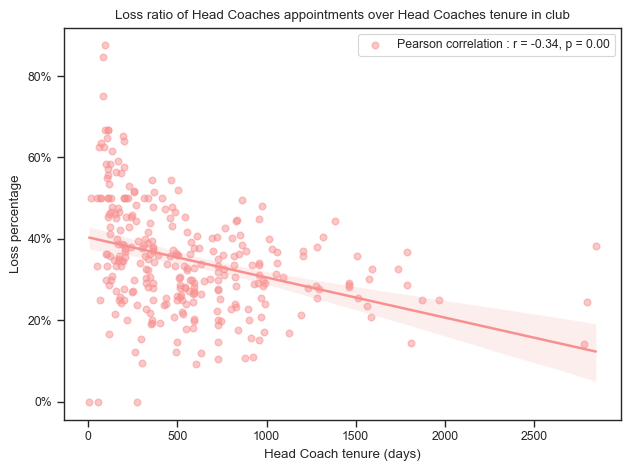

In [17]:
#| label: hc_loss_ratio_over_days
plot_percentage_over_days(head_coach, 'loss_percentage', 'Loss', 'red')

In [18]:
# Plot match outcome of clubs over number of coach seen by club

club_results = head_coach.groupby('team').agg({'wins': 'sum', 'draws': 'sum', 'losses': 'sum', 'matches': 'sum', 'coach_name': 'count'})
club_results = club_results.rename(columns={'coach_name': 'coach_count'})
club_results['win_percentage'] = club_results['wins'] / club_results['matches'] * 100
club_results['draw_percentage'] = club_results['draws'] / club_results['matches'] * 100
club_results['loss_percentage'] = club_results['losses'] / club_results['matches'] * 100

# Plot percentage over number of coach seen by club
def plot_club_outcome(data, y_value, y_leg, color):
    plt.figure()
    sns.regplot(x='coach_count', y=y_value, data=data, color=sns.light_palette(color, as_cmap=True)(0.4), scatter_kws={'alpha':0.5}, label = y_leg + ' ratio')
    # x = number of coach seen by club
    # y = win/draw/loss ratio of the club
    plt.title(f'{y_leg} ratio of clubs over the number of Head Coaches teams had between xx and xx')
    plt.xlabel('Number of coach seen by club')
    plt.ylabel(f'{y_leg} percentage')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    r, p = pearsonr(data['coach_count'], data[y_value])
    plt.legend([f'Pearson correlation : r = {r:.2f}, p = {p:.2f}'], loc='upper right')
    
    # plt.savefig(f'figures/{y_value}_over_club_hc_count.png')

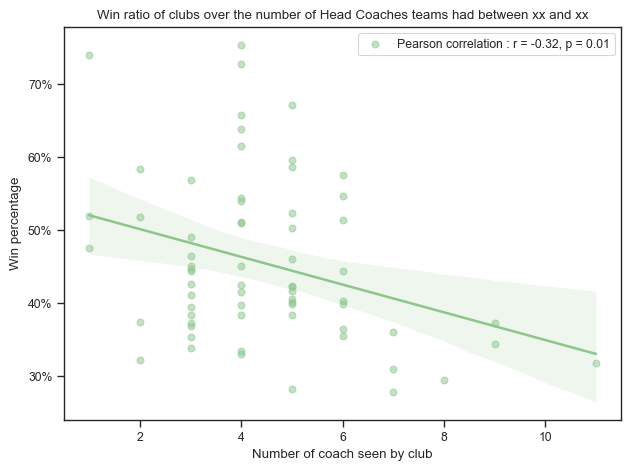

In [19]:
#| label: club_win_ratio_over_coach_count
plot_club_outcome(club_results, 'win_percentage', 'Win', 'green')

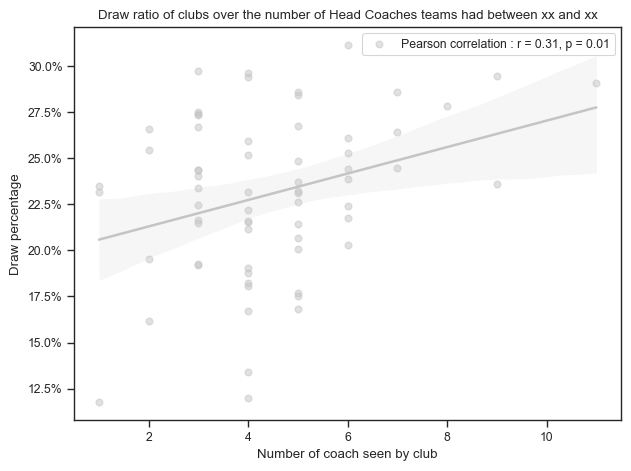

In [20]:
#| label: club_draw_ratio_over_coach_count
plot_club_outcome(club_results, 'draw_percentage', 'Draw', 'gray')

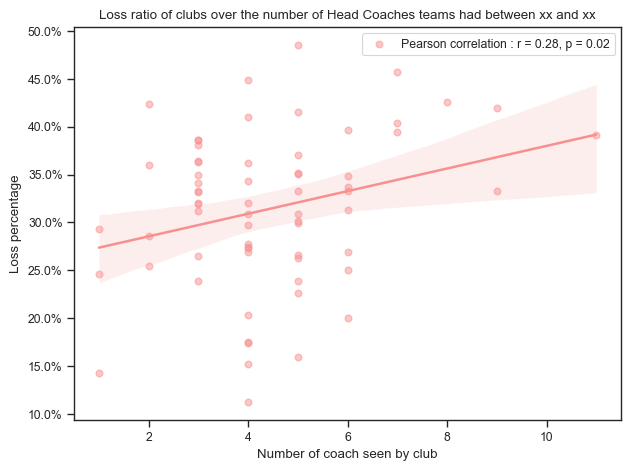

In [21]:
#| label: club_loss_ratio_over_coach_count
plot_club_outcome(club_results, 'loss_percentage', 'Loss', 'red')

In [22]:
# Plot of wins, draw and losses percentage over number of club head coach has been

head_coach_performance = head_coach.groupby('coach_name').agg({'matches': 'sum', 'wins': 'sum', 'draws': 'sum', 'losses': 'sum', 'team': 'count'}).reset_index()
head_coach_performance = head_coach_performance.rename(columns={'team': 'club_count'})
head_coach_performance['win_percentage'] = head_coach_performance['wins'] / head_coach_performance['matches'] * 100
head_coach_performance['draw_percentage'] = head_coach_performance['draws'] / head_coach_performance['matches'] * 100
head_coach_performance['loss_percentage'] = head_coach_performance['losses'] / head_coach_performance['matches'] * 100

# Linear regression plot for wins, draw and losses percentage over number of club head coach has been

def plot_percentage_over_club_count(data, y_value, y_leg, color):
    plt.figure()
    sns.regplot(x='club_count', y=y_value, data=data, color = sns.light_palette(color, as_cmap=True)(0.4), scatter_kws={'alpha':0.5}, label = y_leg + ' ratio')
    # x = number of club head coach has worked for
    # y = win/draw/loss ratio of the head coach over all clubs
    plt.title(f'{y_leg.capitalize()} ratio of Head Coaches over number of clubs Head Coaches worked for')
    plt.xticks(range(1, data['club_count'].max() + 1))
    plt.xlabel('Number of clubs Head Coach have worked for')
    plt.ylabel(f'{y_leg.capitalize()} percentage')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    r, p = pearsonr(data['club_count'], data[y_value])
    plt.legend([f'Pearson correlation : r = {r:.2f}, p = {p:.2f}'], loc='upper right')
    
    # plt.savefig(f'figures/{y_value}_over_club_per_hc_count.png')

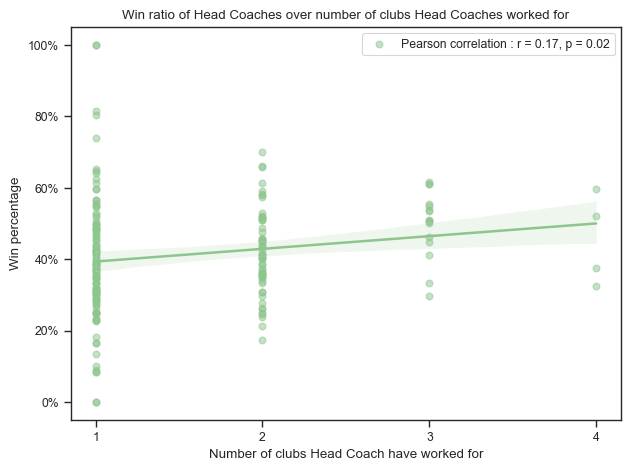

In [23]:
#| label: hc_win_ratio_over_club_count
plot_percentage_over_club_count(head_coach_performance, 'win_percentage', 'win', 'green')


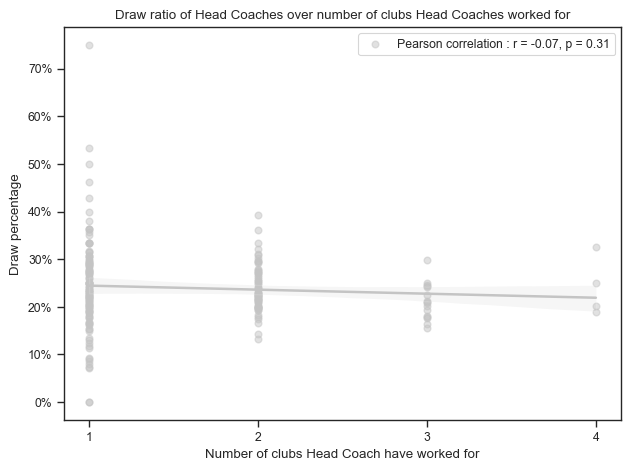

In [24]:
#| label: hc_draw_ratio_over_club_count
plot_percentage_over_club_count(head_coach_performance, 'draw_percentage', 'draw', 'gray')

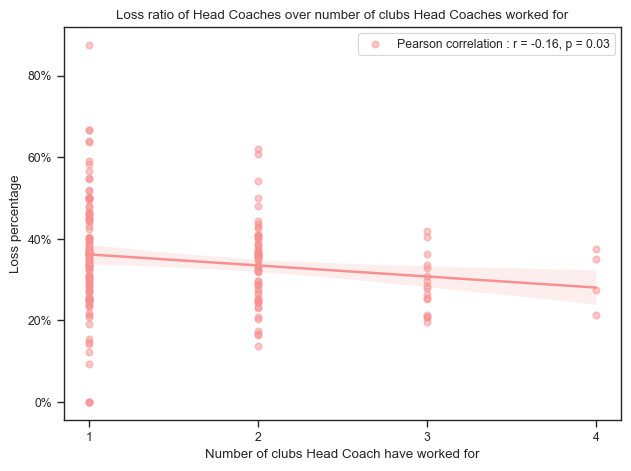

In [25]:
#| label: hc_loss_ratio_over_club_count
plot_percentage_over_club_count(head_coach_performance, 'loss_percentage', 'loss', 'red')